In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
le = preprocessing.LabelEncoder()
from sklearn.model_selection import train_test_split
import pickle
import os


data=pd.read_csv('./data/new_data.csv')

In [37]:
data.head()
data.shape

(101766, 54)

In [38]:
data.dtypes

Unnamed: 0                    int64
encounter_id                  int64
patient_nbr                   int64
race                         object
gender                       object
age                          object
admission_type_id             int64
discharge_disposition_id      int64
admission_source_id           int64
time_in_hospital              int64
payer_code                   object
medical_specialty            object
num_lab_procedures            int64
num_procedures                int64
num_medications               int64
number_outpatient             int64
number_emergency              int64
number_inpatient              int64
number_diagnoses              int64
max_glu_serum                object
A1Cresult                    object
metformin                    object
repaglinide                  object
nateglinide                  object
chlorpropamide               object
glimepiride                  object
acetohexamide                object
glipizide                   

In [39]:
data = data.drop(['Unnamed: 0','patient_nbr','encounter_id', 'payer_code', 'medical_specialty'], axis = 1)


In [40]:
data['admission_type_id'] = pd.Categorical(data.admission_type_id)
data['discharge_disposition_id'] = pd.Categorical(data.discharge_disposition_id)
data['admission_source_id'] = pd.Categorical(data.admission_source_id)

cat_cols = list(data.select_dtypes(include=[object]).columns)

for col in cat_cols:
    data[col] = pd.Categorical(data[col])


In [41]:
col_to_encode = data[list(data.select_dtypes(include=['category']).columns)]


In [42]:
for col in col_to_encode:
    data[col] = le.fit_transform(data[col])


In [43]:
readmitted = data['readmitin30days']
data = data.drop('readmitin30days', axis = 1)

In [44]:
readmitted.value_counts()

0    90409
1    11357
Name: readmitin30days, dtype: int64

In [45]:
data['random'] = np.random.random(size=len(data))

In [53]:
data = data.drop('random', axis = 1)

### Running RandomSearch to narrow down the params

In [48]:
## setting initial search params

model=ensemble.RandomForestClassifier(random_state=0)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_para = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rand_search_rf = RandomizedSearchCV(model, random_para, cv=4)

rand_search_rf.fit(data, readmitted)





{'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 650, 'random_state': 0}
0.8884696263978146


In [52]:
bestparam_rand= rand_search_rf.best_params_
bestscore_rand= rand_search_rf.best_score_

print(bestparam_rand)
print(bestscore_rand)

{'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
0.8884204940746419


In [51]:
np.linspace(start = 900, stop = 1100, num = 5)

array([ 900.,  950., 1000., 1050., 1100.])

In [55]:

##predict test data
#randomForest.predict(test)
model=ensemble.RandomForestClassifier(oob_score = True, random_state=0)

###Grid Search

n_estimators = [1100, 1200, 1300]
max_features = ['sqrt']
max_depth = [50, 55, 60]
min_samples_split = [12, 13, 14]
min_samples_leaf = [2, 3]
bootstrap = [True]
grid_para = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid_search_forest = GridSearchCV(model, grid_para, cv=4)
grid_search_forest.fit(data, readmitted)

bestparam= grid_search_forest.best_params_
bestscore= grid_search_forest.best_score_

# Train test split
#X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_train, y_train,  random_state = 42, test_size = 0.2)







KeyboardInterrupt: 

In [ ]:
# Fit the model
model = ensemble.RandomForestRegressor(**bestparam)
#model.set_params(bestparam)
model.fit(data, readmitted)
model.score(data, readmitted)


In [ ]:
print(bestparam)
print(bestscore)
model.score(data, readmitted)


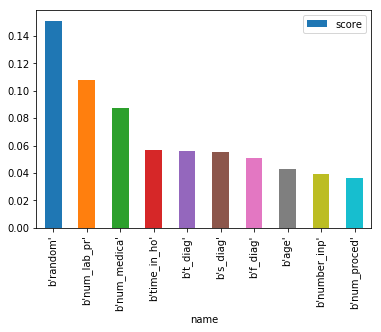

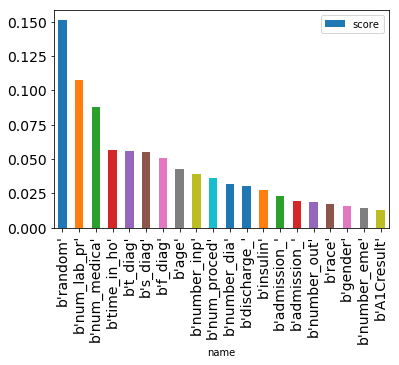

In [23]:
##feature importance
feature_importance = list(zip(data.columns, model.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
fea_i=pd.DataFrame({'name':name,'score':score})
fea_i[:10].plot.bar(x='name', y='score')
fea_i

my_fig = fea_i[:20].plot.bar(x='name', y='score')
my_fig.tick_params(labelsize=14)
#my_fig.figure.savefig('my_fig.png', dpi=300, bbox_inches = 'tight')
